In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage import center_of_mass, median_filter, gaussian_filter
from scipy.optimize import curve_fit

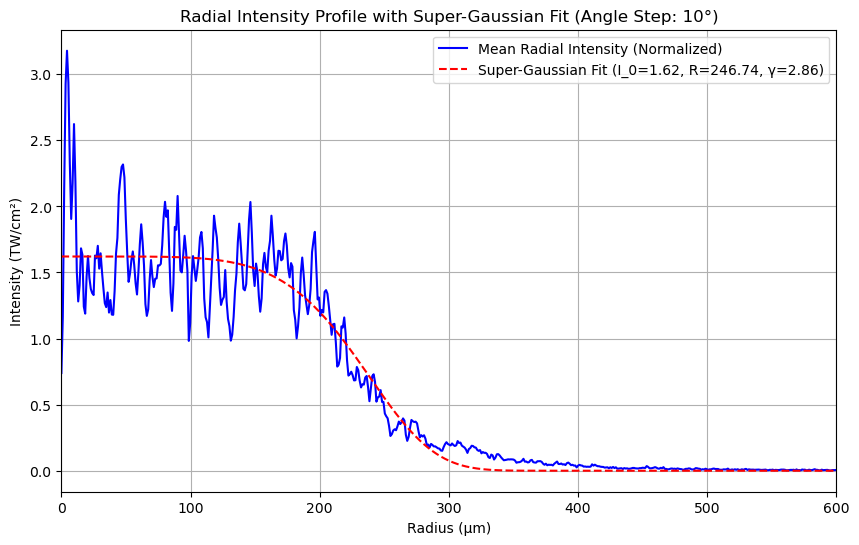

In [8]:
# Define the modified super-Gaussian function with I_0
def super_gaussian(x, I_0, R, gamma):
    # Added a small constant to R to avoid division by zero
    return I_0 * np.exp(-((x / (R + 1e-6)) ** 2) ** gamma)

def analyze_laser_spot(image_path, power_TW=0.003, scale_um_per_px=1.084, angle_step=10, 
                       apply_median=True, median_size=3, apply_gaussian=True, gaussian_sigma=1,
                       percentile=95, x=10):
    # Load the image and convert it to a numpy array
    image = Image.open(image_path)
    image_data = np.array(image, dtype=np.float64)  # Use float for accurate normalization

    # Apply median and Gaussian filters if requested
    if apply_median:
        image_data = median_filter(image_data, size=median_size)
    if apply_gaussian:
        image_data = gaussian_filter(image_data, sigma=gaussian_sigma)

    # Calculate the physical area of each pixel in cm²
    pixel_area_cm2 = (scale_um_per_px * 1e-4) ** 2  # Convert µm to cm for area calculation

    # Calculate the normalization factor to convert relative intensity to physical units (TW/cm²)
    total_intensity = image_data.sum()
    normalization_factor = power_TW / (total_intensity * pixel_area_cm2)  # Unit: TW/cm²

    # Normalize the image data to physical intensity (TW/cm²)
    normalized_image_data = image_data * normalization_factor  # Resulting unit: TW/cm²

    # Calculate center coordinates and maximum radius from the center to image corners
    center_y, center_x = map(int, center_of_mass(normalized_image_data))
    height, width = normalized_image_data.shape

    # Calculate Profile_X as the horizontal coordinate scaled by scale_um_per_px
    Profile_X = (np.arange(width) - center_x) * scale_um_per_px  # Centering Profile_X at center_x

    # Calculate Profile by integrating around center_y in the y-direction by x um
    # Convert x in µm to pixels
    x_pixels = int(x / scale_um_per_px)
    y_start = max(0, center_y - x_pixels)
    y_end = min(height, center_y + x_pixels + 1)
    Profile = np.mean(normalized_image_data[y_start:y_end, :], axis=0)

    # Calculate center coordinates and maximum radius from the center to image corners
    max_radius = int(np.sqrt(center_x ** 2 + center_y ** 2))
    radii = np.arange(0, max_radius) * scale_um_per_px
    angles = np.radians(np.arange(0, 360, angle_step))

    # Array to store radial intensities
    radial_intensities = []
    for theta in angles:
        # Calculate x and y coordinates for each angle along the radius
        x_coords = (center_x + (radii / scale_um_per_px) * np.cos(theta)).astype(int)
        y_coords = (center_y + (radii / scale_um_per_px) * np.sin(theta)).astype(int)
        valid_idx = (x_coords >= 0) & (x_coords < width) & (y_coords >= 0) & (y_coords < height)
        radial_intensities.append(normalized_image_data[y_coords[valid_idx], x_coords[valid_idx]])

    # Ensure all profiles have the same length by padding with NaN
    max_length = max(len(profile) for profile in radial_intensities)
    padded_radial_intensities = np.array([np.pad(profile, (0, max_length - len(profile)), 
                                                 constant_values=np.nan) 
                                          for profile in radial_intensities])

    # Calculate the mean radial intensity, ignoring NaNs
    mean_radial_intensity = np.nanmean(padded_radial_intensities, axis=0)

    # Determine I_0 as the specified percentile value of mean_radial_intensity
    I_0 = np.nanpercentile(mean_radial_intensity, percentile)

    # Fit the mean radial intensity profile using the modified super-Gaussian function
    try:
        # Initial guess for I_0, R, and gamma, with bounds to ensure reasonable values
        popt, _ = curve_fit(super_gaussian, radii[:len(mean_radial_intensity)], mean_radial_intensity, 
                            p0=[I_0, 250, 2], bounds=([0, 1, 1], [I_0*2, 1000, 10]))
        I_0_fit, R_fit, gamma_fit = popt
    except RuntimeError:
        I_0_fit, R_fit, gamma_fit = None, None, None  # Fallback in case fitting fails

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(radii[:len(mean_radial_intensity)], mean_radial_intensity, color='blue', 
            label='Mean Radial Intensity (Normalized)')
    
    # Plot the fitted super-Gaussian curve
    if I_0_fit is not None and R_fit is not None and gamma_fit is not None:
        fitted_curve = super_gaussian(radii[:len(mean_radial_intensity)], I_0_fit, R_fit, gamma_fit)
        ax.plot(radii[:len(fitted_curve)], fitted_curve, 'r--', 
                label=f'Super-Gaussian Fit (I_0={I_0_fit:.2f}, R={R_fit:.2f}, γ={gamma_fit:.2f})')

    # Set labels and title
    ax.set_xlabel('Radius (µm)')
    ax.set_ylabel('Intensity (TW/cm²)')
    ax.set_title(f'Radial Intensity Profile with Super-Gaussian Fit (Angle Step: {angle_step}°)')
    ax.legend()
    ax.grid(True)


    return fig, ax, radii, mean_radial_intensity, I_0_fit, R_fit, gamma_fit,Profile_X, Profile

# Example usage with adjustable power and percentile for I_0
(fig, ax, 
 radii, mean_radial_intensity, 
 I_0_fit, R_fit, gamma_fit,
 Profile_X, Profile) = analyze_laser_spot(
    'Technical question call proposal.tiff', power_TW=0.003, scale_um_per_px=1.084, angle_step=10,
    apply_median=False, median_size=5, apply_gaussian=False, gaussian_sigma=1, percentile=95,x = 5)

# Customize plot
# ax.set_ylim(0, 1.5)
ax.set_xlim(0, 600)
plt.show(block=False)

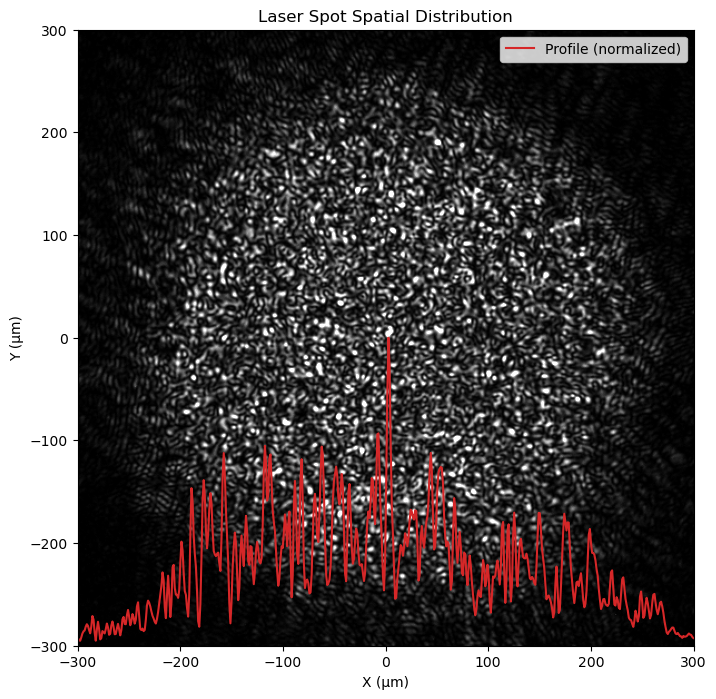

In [9]:
def visualize_laser_spot(image_path, scale_um_per_px=1.084, apply_median=False, median_size=3, 
                         apply_gaussian=False, gaussian_sigma=1, x=10, xy_range=(500, 500)):
    """
    Visualize the laser spot's spatial distribution with optional median and Gaussian filtering, 
    normalized coordinates, and an overlay of the horizontal Profile.
    
    Parameters:
    image_path (str): Path to the laser spot image.
    scale_um_per_px (float): Scale factor in um per pixel for spatial normalization.
    apply_median (bool): Whether to apply median filtering (default: False).
    median_size (int): Size of the median filter (default: 3).
    apply_gaussian (bool): Whether to apply Gaussian filtering (default: False).
    gaussian_sigma (float): Sigma for Gaussian filter (default: 1).
    x (float): Integration range in um for Profile calculation.
    xy_range (tuple): Range for x and y axis limits (default: (500, 500)).

    Returns:
    fig, ax: Matplotlib figure and axes with the laser spot visualization.
    """

    # Load the image and convert it to a numpy array
    image = Image.open(image_path)
    image_data = np.array(image, dtype=np.float64)

    # Apply median and Gaussian filters if requested
    if apply_median:
        image_data = median_filter(image_data, size=median_size)
    if apply_gaussian:
        image_data = gaussian_filter(image_data, sigma=gaussian_sigma)

    # Get image dimensions and calculate center of mass
    height, width = image_data.shape
    center_y, center_x = center_of_mass(image_data)

    # Normalize coordinates by scale factor and set center of mass as the origin
    x_coords = (np.arange(width) - center_x) * scale_um_per_px
    y_coords = (center_y - np.arange(height)) * scale_um_per_px  # Flip y-coordinates to make it increasing

    # Calculate Profile by averaging around center_y in the y-direction by x um
    x_pixels = int(x / scale_um_per_px)
    y_start = max(0, int(center_y) - x_pixels)
    y_end = min(height, int(center_y) + x_pixels + 1)
    Profile = np.mean(image_data[y_start:y_end, :], axis=0)

    # Normalize Profile
    Profile_min = -xy_range[1]  # Set minimum of Profile to -xy_range[1]
    Profile_max = 0             # Set maximum of Profile to 0
    Profile = (Profile - Profile.max()) / (Profile.min() - Profile.max()) * (Profile_min - Profile_max) + Profile_max

    # Set vmin and vmax for imshow based on percentiles of the data
    vmin = np.percentile(image_data, 0.1)  # 0.1% percentile
    vmax = np.percentile(image_data, 99.9)  # 99.9% percentile

    # Plot the spatial distribution with normalized coordinates
    fig, ax = plt.subplots(figsize=(8, 8))
    extent = [x_coords[0], x_coords[-1], y_coords[-1], y_coords[0]]  # Set extent to make y-axis increasing
    ax.imshow(image_data, extent=extent, cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_xlabel("X (µm)")
    ax.set_ylabel("Y (µm)")
    ax.set_title("Laser Spot Spatial Distribution")

    # Set axis limits based on xy_range
    ax.set_xlim(-xy_range[0], xy_range[0])
    ax.set_ylim(-xy_range[1], xy_range[1])

    # Overlay normalized Profile on the plot
    ax.plot(x_coords, Profile, label="Profile (normalized)",
            color='tab:red', alpha=1)
    ax.legend()

    plt.show(block=False)
    return fig, ax



fig, ax = visualize_laser_spot('Technical question call proposal.tiff', scale_um_per_px=1.084, apply_median=False, median_size=3, 
                         apply_gaussian=False, gaussian_sigma=1, x=10, xy_range=(300, 300))


In [205]:
from scipy.signal import detrend, butter, filtfilt

from scipy.signal import detrend, butter, filtfilt

def analyze_profile_modulation(profile_data, r_data, r_range=(0, 200), apply_highpass=False, cutoff_wavelength=100):
    """
    Analyze the modulation characteristics of a radial intensity profile within a specified range,
    with optional detrending and high-pass filtering to reduce low-frequency components.
    
    Parameters:
    profile_data (numpy array): Array of intensity values (profile data).
    r_data (numpy array): Array of corresponding radial distances.
    r_range (tuple): Tuple specifying the range of 'r' values to analyze (default is (0, 200)).
    apply_highpass (bool): Whether to apply a high-pass filter to remove low-frequency components.
    cutoff_wavelength (float): The cutoff wavelength for the high-pass filter in um (default is 100 um).
    
    Returns:
    tuple: Dominant frequency and corresponding characteristic wavelength within the specified range.
    """
    import numpy as np
    from scipy.fft import fft, fftfreq
    import matplotlib.pyplot as plt

    # Filter data within the specified range of r
    within_range = (r_data >= r_range[0]) & (r_data <= r_range[1])
    r_filtered = r_data[within_range]
    profile_filtered_raw = profile_data[within_range]

    # Remove linear trend from the profile data
    profile_filtered = detrend(profile_filtered_raw)

    # Apply high-pass filter if requested
    if apply_highpass:
        # Convert cutoff wavelength to cutoff frequency
        cutoff_frequency = 1 / cutoff_wavelength  # Cutoff frequency in 1/um
        nyquist_rate = 0.5 / np.mean(np.diff(r_filtered))  # Nyquist frequency based on sampling rate
        normal_cutoff = cutoff_frequency / nyquist_rate  # Normalize cutoff frequency
        b, a = butter(1, normal_cutoff, btype='high', analog=False)  # 1st order Butterworth filter
        profile_filtered = filtfilt(b, a, profile_filtered)  # Apply the filter

    # Calculate the step size for r_filtered to ensure accurate frequency calculation
    r_step = np.mean(np.diff(r_filtered))

    # Perform Fourier Transform on the filtered profile data
    fft_profile_filtered = fft(profile_filtered - np.mean(profile_filtered))  # Remove DC component
    frequencies_filtered = fftfreq(len(profile_filtered), d=r_step)

    # Extract the positive half of the frequency spectrum and corresponding amplitude
    positive_freqs_filtered = frequencies_filtered[:len(frequencies_filtered)//2]
    amplitudes_filtered = np.abs(fft_profile_filtered[:len(frequencies_filtered)//2])
    
    # Filter out the zero frequency to avoid division by zero in wavelength calculation
    nonzero_freqs = positive_freqs_filtered[positive_freqs_filtered != 0]
    nonzero_amplitudes = amplitudes_filtered[positive_freqs_filtered != 0]
    wavelengths_filtered = 1 / nonzero_freqs  # Convert frequencies to wavelengths

    # Find the dominant frequency and corresponding characteristic wavelength
    dominant_freq_filtered = nonzero_freqs[np.argmax(nonzero_amplitudes)]
    characteristic_wavelength_filtered = 1 / dominant_freq_filtered if dominant_freq_filtered != 0 else None

    # Plot the original profile and Fourier Transform with wavelength as x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plot profile intensity within specified r range
    ax1.plot(r_filtered, profile_filtered_raw, label="Profile Intensity (Detrended and Filtered)" if apply_highpass else "Profile Intensity (Detrended)")
    ax1.set_xlabel("Radial Distance (um)")
    ax1.set_ylabel("Intensity")
    ax1.set_title(f"Profile Intensity (r = {r_range[0]} to {r_range[1]} um)")
    ax1.grid(True)
    ax1.legend()

    # Plot Fourier Transform amplitude with wavelength as x-axis
    ax2.plot(wavelengths_filtered, nonzero_amplitudes, color='orange', label="Fourier Transform Amplitude")
    ax2.set_xlabel("Wavelength (um)")
    ax2.set_ylabel("Amplitude")
    ax2.set_title(f"Fourier Transform of Profile Intensity (r = {r_range[0]} to {r_range[1]} um)")
    ax2.set_xlim(0, np.max(wavelengths_filtered))  # Limit x-axis to finite wavelengths
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return dominant_freq_filtered, characteristic_wavelength_filtered


profile_data = Profile
r_data = Profile_X

# Run the function with the given profile and r data over the default range (0, 200)
analyze_profile_modulation(profile_data, r_data, r_range=(-100, 100), apply_highpass=True, cutoff_wavelength=100)


array([1199, 1198, 1197, ...,    2,    1,    0])